# 1. Import Libraries

In [18]:
from IPython.display import display, HTML
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix

In [19]:
# display the DataFrame as a scrollable table
def display_scrollable(df, max_height=300):
    display(HTML(f"""
        <div style="max-height: {max_height}px; overflow-y: auto;">
            {df.to_html()}
        </div>
    """))

# 2. Global Constants

In [20]:
RANDOM_STATE_SEED = 420
DATA_FILE_PATH = r"C:\Users\helen\Documents\Concordia University\fall 2024\INSE 6120\project code\tamer-thamoqa\processed_friday_dataset_with_attack_names.csv"
MODEL_FILE_PATH = r"C:\Users\helen\Documents\Concordia University\fall 2024\INSE 6120\project code\tamer-thamoqa\decision-tree-classifier.pkl"
TEST_SIZE = 0.3

In [21]:
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.max_rows', None)  # show all rows
pd.set_option('display.width', None)  # adjust width to avoid line breaks


# 3. Data Preparation
Load, split, normalize, and prepare features and labels

## 3.1. Load Dataset

In [22]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load the dataset from a specified csv file path.

    args:
        file_path (str): path to the csv file

    returns:
        pd.DataFrame: loaded dataset as a dataframe
    """
    return pd.read_csv(file_path)

## 3.2. Split Data into Training and Testing Sets

In [23]:
def split_data(df: pd.DataFrame, test_size: float = TEST_SIZE) -> tuple:
    """
    Split data into training and testing sets.

    args:
        df (pd.DataFrame): the original dataset
        test_size (float): proportion of the data to include in the test split

    returns:
        tuple: train and test dataframes
    """
    return train_test_split(df, test_size=test_size, random_state=RANDOM_STATE_SEED)

## 3.3. Normalize Data

In [24]:
def normalize_data(train: pd.DataFrame, test: pd.DataFrame, numerical_cols: list) -> tuple:
    """
    Normalize training and testing data using MinMaxScaler, without modifying inputs in place.

    args:
        train (pd.DataFrame): training dataset
        test (pd.DataFrame): testing dataset
        numerical_cols (list): list of numerical columns to normalize

    returns:
        tuple: normalized training and testing datasets, fitted scaler
    """
    scaler = MinMaxScaler().fit(train[numerical_cols])
    
    # create copies of train and test to avoid modifying them in place
    train_scaled = train.copy()
    test_scaled = test.copy()
    
    train_scaled[numerical_cols] = scaler.transform(train[numerical_cols])
    test_scaled[numerical_cols] = scaler.transform(test[numerical_cols])
    
    return train_scaled, test_scaled, scaler


## 3.4. Prepare Features and Labels

In [25]:
def separate_features_labels(df: pd.DataFrame, label_col: str = "Label", attack_name_col: str = "Attack Name") -> tuple:
    """
    Separate features and labels from the DataFrame, while retaining the 'Attack Name' column for mapping.

    args:
        df (pd.DataFrame): the dataset
        label_col (str): column name of the labels
        attack_name_col (str): column name of the attack names for later reference

    returns:
        tuple: numpy arrays of features (X), labels (y), and attack names (attack_names)
    """
    # make a copy of the dataframe to avoid in-place modification
    df_copy = df.copy()
    
    # get labels (0 or 1)
    y = np.array(df_copy.pop(label_col))  # pop removes label column from the dataframe
    
    # pop out attack names directly
    attack_names = df_copy.pop(attack_name_col) if attack_name_col in df_copy.columns else None

    # get features
    X = df_copy.values
    return X, y, attack_names


# 4. Load Pre-trained Model

In [26]:
def load_model(model_path: str):
    """
    Load a pre-trained model from a file.

    args:
        model_path (str): path to the saved model file

    returns:
        loaded model object
    """
    return joblib.load(model_path)

In [27]:
# load the pre-trained model
model = load_model(MODEL_FILE_PATH)

# 5. Load and Prepare Dataset

In [28]:
# load the whole dataset
df_dataset = load_data(DATA_FILE_PATH)  

## 5.1. Load Original Data Split (Benign vs. Malicious)

In [29]:
# split into train and test set according to the original split used to train the model
train_raw, test_raw = split_data(df_dataset)

# specify which columns to normalize (only normalise numerical columns)
numerical_cols = df_dataset.columns[:-3]  

# normalise train and test set, define the scaler that can be used to normalise new crafted test samples
train_normalized, test_normalized, scaler = normalize_data(train_raw, test_raw, numerical_cols)  

# separate features from "Label" and "Attack Name" columns
X_train, y_train, train_attack_names = separate_features_labels(train_normalized)
X_test, y_test, test_attack_names = separate_features_labels(test_normalized)

## 5.2. Prepare Non-Normalised DataFrame for Evaluation

In [30]:
def prepare_for_evaluation(df: pd.DataFrame, scaler, label_col: str = "Label", attack_name_col: str = "Attack Name", numerical_cols: list = df_dataset.columns[:-3]) -> tuple:
    """
    Prepares raw, non-normalized data for model evaluation by normalizing, 
    separating features, and returning arrays ready for input to the model.

    Args:
        df (pd.DataFrame): raw, non-normalized data
        scaler (MinMaxScaler): fitted scaler from the training data
        label_col (str): name of the column containing labels
        attack_name_col (str): name of the column containing attack names
        numerical_cols (list): list of numerical columns to normalize

    Returns:
        tuple: containing normalized features (X), labels (y), and attack names
    """
    # create a copy of the data to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # apply scaler to numerical columns
    df_copy[numerical_cols] = scaler.transform(df_copy[numerical_cols])
    
    # separate features, labels, and attack names
    X, y, attack_names = separate_features_labels(df_copy, label_col, attack_name_col)
    
    return X, y, attack_names


## 5.2. Separate Dataframes for Each Attack Type in the Test Set

In [31]:
# create separate dataframes for each type
bot_df = test_raw[test_raw['Attack Name'] == 'Bot'].copy()
dos_hulk_df = test_raw[test_raw['Attack Name'] == 'DoS attacks-Hulk'].copy()
dos_slowhttptest_df = test_raw[test_raw['Attack Name'] == 'DoS attacks-SlowHTTPTest'].copy()


In [32]:
# display distributions and basic stats to confirm separation
print("Bot samples:", bot_df.shape[0])
print("DoS Hulk samples:", dos_hulk_df.shape[0])
print("DoS SlowHTTPTest samples:", dos_slowhttptest_df.shape[0])

Bot samples: 43298
DoS Hulk samples: 43514
DoS SlowHTTPTest samples: 25


In [33]:
# separate features, labels, and attack names for each attack type
X_bot, y_bot, bot_attack_names = prepare_for_evaluation(bot_df, scaler)
X_dos_hulk, y_dos_hulk, dos_hulk_attack_names = prepare_for_evaluation(dos_hulk_df, scaler)
X_dos_slowhttptest, y_dos_slowhttptest, dos_slowhttptest_attack_names = prepare_for_evaluation(dos_slowhttptest_df, scaler)


## 5.3. Separate Dataframes for Each Label in the Test Set (0 and 1)

In [34]:
# create separate dataframes for each type
benign_df = test_raw[test_raw['Label'] == 0].copy()
malicious_df = test_raw[test_raw['Label'] == 1].copy()

# display distributions 
print("Benign samples:", benign_df.shape[0])
print("Malicious samples:", malicious_df.shape[0])

# separate features, labels, and attack names
X_benign, y_benign, benign_attack_names = prepare_for_evaluation(benign_df, scaler)
X_malicious, y_malicious, malicious_attack_names = prepare_for_evaluation(malicious_df, scaler)

Benign samples: 322493
Malicious samples: 86837


# 6. Evaluate Results

In [35]:
def evaluate_model(model, X_test: np.ndarray, y_test: np.ndarray):
    """
    Evaluate the model on test data and return accuracy, precision, recall, f1-score, and confusion matrix.

    args:
        model: trained model to evaluate
        X_test (np.ndarray): test features
        y_test (np.ndarray): true labels for the test set

    returns:
        dict: dictionary containing accuracy, precision, recall, f1-score, and confusion matrix
    """
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted')
    cm = confusion_matrix(y_test, predictions)
    
    # print classification report for a more detailed breakdown
    #report = classification_report(y_test, predictions, zero_division=0)
    #print("classification report:\n", report)
    
    print(f"accuracy: {accuracy:.5f}")
    print(f"precision: {precision:.5f}")
    print(f"recall: {recall:.5f}")
    print(f"f1-score: {f1:.5f}")
    print("confusion matrix:")
    print(cm)
    
    # return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

## 6.1. Evaluate Crafted Samples From a .csv File

### 6.1.1. Aathira's Crafted Samples

In [36]:
crafted_dos_aathira_file = r"C:\Users\helen\Documents\Concordia University\fall 2024\INSE 6120\project code\data\aathira\ATTACKS_modified_features.csv" 
crafted_dos_aathira_df = load_data(crafted_dos_aathira_file)

In [37]:
X_crafted_dos, y_crafted_dos, _ = prepare_for_evaluation(crafted_dos_aathira_df, scaler)

In [38]:
crafted_dos_results = evaluate_model(model, X_crafted_dos, y_crafted_dos)

accuracy: 0.19444
precision: 0.08507
recall: 0.19444
f1-score: 0.11836
confusion matrix:
[[ 7  0  0  0]
 [ 9  0  0  0]
 [ 0 11  0  0]
 [ 0  9  0  0]]


In [39]:
crafted_dos_aathira_df[crafted_dos_aathira_df['Label'] == 1]

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
0,285899.978685,2,2,1334.896082,702.179501,326,0,108.666667,188.216188,112,0,32.25,53.767245,13713.644249,6080.854855,15084,1,645,322.5,374.059487,587,58,15513,5171.000000,8587.564206,15084,1,72,92,53.335697,21.959764,0,326,56.875,115.406657,13318.69643,0,0,1,1,0,0,0,1,1,65.0,108.666667,32.25,0,0,0,0,0,0,3,326,4,129,8192,219,1,20,0,0,0,0,0,0,0,0,False,True,1
1,254364.834254,2,2,1142.753532,1071.365766,0,0,0.000000,0.000000,0,0,0.00,0.000000,8460.583978,0.000000,577,577,577,577.0,0.000000,577,577,0,0.000000,0.000000,0,0,40,0,31.091791,60.403589,0,0,0.000,0.000000,0.00000,0,0,0,0,1,0,0,0,0,0.0,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,2052,-1,0,20,0,0,0,0,0,0,0,0,False,True,1
2,222401.555862,2,2,749.693509,514.234963,326,0,108.666667,188.216188,112,0,32.25,53.767245,8810.185556,3693.591716,9243,20,577,288.5,335.875721,526,51,9773,3257.666667,5185.563165,9243,117,72,92,91.003406,97.331325,0,326,56.875,115.406657,13318.69643,0,0,1,1,0,0,0,1,1,65.0,108.666667,32.25,0,0,0,0,0,0,3,326,4,129,8192,219,1,20,0,0,0,0,0,0,0,0,False,True,1
3,264794.403477,2,2,631.560816,1016.411343,0,0,0.000000,0.000000,0,0,0.00,0.000000,12670.648846,0.000000,457,457,457,457.0,0.000000,457,457,0,0.000000,0.000000,0,0,40,0,35.677122,50.475766,0,0,0.000,0.000000,0.00000,0,0,0,0,1,0,0,0,0,0.0,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,2052,-1,0,20,0,0,0,0,0,0,0,0,False,True,1
4,288159.373435,2,2,743.056310,724.428793,326,0,108.666667,188.216188,112,0,32.25,53.767245,13399.171985,3786.768196,9434,20,502,251.0,288.499567,455,47,9836,3278.666667,5333.075692,9434,41,72,92,74.049897,69.698159,0,326,56.875,115.406657,13318.69643,0,0,1,1,0,0,0,1,1,65.0,108.666667,32.25,0,0,0,0,0,0,3,326,4,129,8192,219,1,20,0,0,0,0,0,0,0,0,False,True,1
5,214299.683731,2,2,1310.036842,842.782296,0,0,0.000000,0.000000,0,0,0.00,0.000000,5610.680412,0.000000,465,465,465,465.0,0.000000,465,465,0,0.000000,0.000000,0,0,40,0,65.743884,45.843590,0,0,0.000,0.000000,0.00000,0,0,0,0,1,0,0,0,0,0.0,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,2052,-1,0,20,0,0,0,0,0,0,0,0,False,True,1
6,204089.127591,2,2,942.613748,709.160083,326,0,108.666667,188.216188,112,0,32.25,53.767245,14677.817643,3781.242728,9425,19,531,265.5,304.763023,481,50,9829,3276.333333,5327.614507,9425,32,72,92,17.096251,15.229281,0,326,56.875,115.406657,13318.69643,0,0,1,1,0,0,0,1,1,65.0,108.666667,32.25,0,0,0,0,0,0,3,326,4,129,8192,219,1,20,0,0,0,0,0,0,0,0,False,True,1
7,135618.429804,2,2,574.058425,756.511179,0,0,0.000000,0.000000,0,0,0.00,0.000000,14019.795081,0.000000,495,495,495,495.0,0.000000,495,495,0,0.000000,0.000000,0,0,40,0,29.899590,94.897034,0,0,0.000,0.000000,0.00000,0,0,0,0,1,0,0,0,0,0.0,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,2052,-1,0,20,0,0,0,0,0,0,0,0,False,True,1
8,283405.747755,2,2,1205.610217,1001.704925,326,0,108.666667,188.216188,112,0,32.25,53.767245,7651.317328,4130.349755,10260,1,480,240.0,270.114790,431,49,10602,3534.000000,5827.367073,10260,1,72,92,85.286435,43.596225,0,326,56.875,115.406657,13318.69643,0,0,1,1,0,0,0,1,1,65.0,108.666667,32.25,0,0,0,0,0,0,

In [40]:
crafted_dos_aathira_df['Label'].nunique()

4

In [41]:
len(crafted_dos_aathira_df)

36

In [42]:
crafted_dos_predictions = model.predict(X_crafted_dos)
print(f"dos predictions: {crafted_dos_predictions}")
print(f"true labels: {y_crafted_dos}")


dos predictions: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
true labels: [1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0]


# 7. Original Model Performance

In [43]:
baseline_results = evaluate_model(model, X_test, y_test)

accuracy: 0.99982
precision: 0.99982
recall: 0.99982
f1-score: 0.99982
confusion matrix:
[[322446     47]
 [    25  86812]]


In [44]:
dos_hulk_results = evaluate_model(model, X_dos_hulk, y_dos_hulk)

accuracy: 1.00000
precision: 1.00000
recall: 1.00000
f1-score: 1.00000
confusion matrix:
[[43514]]


In [45]:
dos_slowhttptest_results = evaluate_model(model, X_dos_slowhttptest, y_dos_slowhttptest)

accuracy: 1.00000
precision: 1.00000
recall: 1.00000
f1-score: 1.00000
confusion matrix:
[[25]]


In [46]:
bot_results = evaluate_model(model, X_bot, y_bot)

accuracy: 0.99942
precision: 1.00000
recall: 0.99942
f1-score: 0.99971
confusion matrix:
[[    0     0]
 [   25 43273]]


**NOTE**: 
- all DoS attack have been identified by the model
- 25 samples of Bot attack have been classified as benign

# 8. Exploratory Data Analysis

In [47]:
df_dataset.head(3)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label,Attack Name
0,141385,9,7,553,3773.0,202,0,61.444444,87.534438,1460,0,539.0,655.432936,9425.666667,19069.116850,73403.0,1.0,141385.0,17673.125,23965.32327,73403.0,22.0,51417.0,8569.50000,13036.89082,31525.0,1.0,192,152,63.655975,49.510203,0,1460,254.470588,474.712955,225352.389700,0,0,1,1,0,0,0,1,0,270.375000,61.444444,539.0,0,0,0,0,0,0,9,553,7,3773,8192,119,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Benign
1,281,2,1,38,0.0,38,0,19.000000,26.870058,0,0,0.0,0.000000,140.500000,174.655375,264.0,17.0,281.0,281.000,0.00000,281.0,281.0,0.0,0.00000,0.00000,0.0,0.0,40,20,7117.437722,3558.718861,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,0,25.333333,19.000000,0.0,0,0,0,0,0,0,2,38,1,0,123,0,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Benign
2,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,1460,0,701.8,636.314186,11192.960000,24379.448340,112589.0,1.0,279728.0,27972.800,36167.74032,112589.0,94.0,258924.0,18494.57143,36356.50372,133669.0,1.0,232,312,39.310424,53.605123,0,1460,430.111111,566.234209,320621.179500,0,0,1,1,0,0,0,1,1,446.653846,98.727273,701.8,0,0,0,0,0,0,11,1086,15,10527,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Benign


In [48]:
train_raw.head(3)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label,Attack Name
358501,1932,1,1,34,211.0,34,34,34.000000,0.000000,211,211,211.00,0.000000,1932.0,0.000000,1932.0,1932.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8,8,517.598344,517.598344,34,211,93.000000,102.190998,10443.000000,0,0,0,0,0,0,0,0,1,139.5,34.000000,211.00,0,0,0,0,0,0,1,34,1,211,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,Benign
205523,10230,3,4,326,129.0,326,0,108.666667,188.216188,112,0,32.25,53.767245,1705.0,3758.395615,9367.0,17.0,585.0,292.5,333.047294,528.0,57.0,9723.0,3241.0,5307.714009,9367.0,17.0,72,92,293.255132,391.006843,0,326,56.875000,115.406657,13318.696430,0,0,1,1,0,0,0,1,1,65.0,108.666667,32.25,0,0,0,0,0,0,3,326,4,129,8192,219,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Bot
334013,29643,1,1,32,121.0,32,32,32.000000,0.000000,121,121,121.00,0.000000,29643.0,0.000000,29643.0,29643.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8,8,33.734777,33.734777,32,121,61.666667,51.384174,2640.333333,0,0,0,0,0,0,0,0,1,92.5,32.000000,121.00,0,0,0,0,0,0,1,32,1,121,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,Benign


In [49]:
train_normalized.head(3)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label,Attack Name
358501,0.000016,0.000000,0.000014,0.000031,0.000002,0.011676,0.023288,0.023288,0.000000,0.024286,0.147552,0.107875,0.000000,0.000016,0.000000,0.000016,1.610000e-05,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000004,0.000006,0.000173,0.000259,0.027597,0.024286,0.063949,0.079365,0.006299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006757,0.082667,0.023288,0.107875,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000031,0.000014,0.000002,0.000000,0.000000,0.000000,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,Benign
205523,0.000085,0.000046,0.000058,0.000296,0.000001,0.111951,0.000000,0.074429,0.182314,0.012891,0.000000,0.016488,0.043261,0.000014,0.000044,0.000078,1.416667e-07,0.000005,0.000002,0.000004,0.000004,4.750000e-07,0.000081,0.000027,0.000063,0.000078,1.416667e-07,0.000032,0.000066,0.000098,0.000196,0.000000,0.037523,0.039109,0.089629,0.008033,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.006757,0.038519,0.074429,0.016488,0.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000296,0.000058,0.000001,0.125015,0.003357,0.000108,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,Bot
334013,0.000247,0.000000,0.000014,0.000029,0.000001,0.010989,0.021918,0.021918,0.000000,0.013927,0.084615,0.061862,0.000000,0.000247,0.000000,0.000247,2.470250e-04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000004,0.000006,0.000011,0.000017,0.025974,0.013927,0.042404,0.039907,0.001593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006757,0.054815,0.021918,0.061862,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000029,0.000014,0.000001,0.000000,0.000000,0.000000,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,Benign


## 8.1. Label and Attack Distribution

In [50]:
# check the label distribution in the original dataset
print("Original dataset label distribution:")
print(df_dataset["Label"].value_counts(normalize=True))  # Set normalize=True for percentage

# check the label distribution in the training set
print("\nTraining set label distribution:")
print(train_raw["Label"].value_counts(normalize=True))

# check the label distribution in the test set
print("\nTest set label distribution:")
print(test_raw["Label"].value_counts(normalize=True))


Original dataset label distribution:
0    0.787392
1    0.212608
Name: Label, dtype: float64

Training set label distribution:
0    0.787193
1    0.212807
Name: Label, dtype: float64

Test set label distribution:
0    0.787856
1    0.212144
Name: Label, dtype: float64


In [51]:
# check the attack distribution in the original dataset
print("Original dataset label distribution:")
print(df_dataset["Attack Name"].value_counts(normalize=True))  # Set normalize=True for percentage

# check the attack distribution in the training set
print("\nTraining set label distribution:")
print(train_raw["Attack Name"].value_counts(normalize=True))

# check the attack distribution in the test set
print("\nTest set label distribution:")
print(test_raw["Attack Name"].value_counts(normalize=True))

Original dataset label distribution:
Benign                      0.787392
DoS attacks-Hulk            0.106606
Bot                         0.105931
DoS attacks-SlowHTTPTest    0.000072
Name: Attack Name, dtype: float64

Training set label distribution:
Benign                      0.787193
DoS attacks-Hulk            0.106734
Bot                         0.105996
DoS attacks-SlowHTTPTest    0.000076
Name: Attack Name, dtype: float64

Test set label distribution:
Benign                      0.787856
DoS attacks-Hulk            0.106305
Bot                         0.105778
DoS attacks-SlowHTTPTest    0.000061
Name: Attack Name, dtype: float64


**NOTE**: the original author did not use "stratify" when splitting the data into train and test sets, but we can see that the label distributions between the original dataset, training set, and test set rather close; the splits seem to maintain a fair representation of each class.   

## 8.2 Feature Dependencies

In [52]:
# list of features
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364431 entries, 0 to 1364430
Data columns (total 74 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Flow Duration      1364431 non-null  int64  
 1   Tot Fwd Pkts       1364431 non-null  int64  
 2   Tot Bwd Pkts       1364431 non-null  int64  
 3   TotLen Fwd Pkts    1364431 non-null  int64  
 4   TotLen Bwd Pkts    1364431 non-null  float64
 5   Fwd Pkt Len Max    1364431 non-null  int64  
 6   Fwd Pkt Len Min    1364431 non-null  int64  
 7   Fwd Pkt Len Mean   1364431 non-null  float64
 8   Fwd Pkt Len Std    1364431 non-null  float64
 9   Bwd Pkt Len Max    1364431 non-null  int64  
 10  Bwd Pkt Len Min    1364431 non-null  int64  
 11  Bwd Pkt Len Mean   1364431 non-null  float64
 12  Bwd Pkt Len Std    1364431 non-null  float64
 13  Flow IAT Mean      1364431 non-null  float64
 14  Flow IAT Std       1364431 non-null  float64
 15  Flow IAT Max       1364431 non-n

## 8.3. Feature Statistics

In [53]:
# stats of the whole dataset
display_scrollable(df_dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Flow Duration,1364431.0,1.069897e+07,2.677867e+07,0.0,21471.000000,2.849854e+06,4.405863e+06,1.200000e+08
Tot Fwd Pkts,1364431.0,6.070358e+00,7.803839e+01,1.0,3.000000,5.000000e+00,5.000000e+00,4.315900e+04
Tot Bwd Pkts,1364431.0,6.486619e+00,1.866906e+02,0.0,1.000000,3.000000e+00,4.000000e+00,6.924100e+04
TotLen Fwd Pkts,1364431.0,6.095703e+02,1.902118e+03,0.0,45.000000,5.040000e+02,9.350000e+02,1.100627e+06
TotLen Bwd Pkts,1364431.0,4.195799e+03,2.707892e+05,0.0,102.000000,3.210000e+02,4.880000e+02,1.010000e+08
Fwd Pkt Len Max,1364431.0,4.695115e+02,3.923194e+02,0.0,39.000000,3.470000e+02,9.350000e+02,2.912000e+03
Fwd Pkt Len Min,1364431.0,4.712483e+00,1.660898e+01,0.0,0.000000,0.000000e+00,0.000000e+00,1.460000e+03
Fwd Pkt Len Mean,1364431.0,1.034026e+02,7.653406e+01,0.0,32.000000,1.086667e+02,1.870000e+02,1.460000e+03
Fwd Pkt Len Std,1364431.0,1.994619e+02,1.731845e+02,0.0,0.000000,1.882162e+02,4.181447e+02,1.032376e+03
Bwd Pkt Len Max,1364431.0,3.935097e+02,4.337523e+02,0.0,92.000000,3.130000e+02,3.840000e+02,8.688000e+03


In [54]:
# stats for benign samples
benign_stats = df_dataset[df_dataset["Label"] == 0].describe().transpose()
display_scrollable(benign_stats[['mean', 'std', 'max', 'min']])

,mean,std,max,min
Flow Duration,1.344148e+07,2.947063e+07,1.200000e+08,0.0
Tot Fwd Pkts,6.921340e+00,8.792244e+01,4.315900e+04,1.0
Tot Bwd Pkts,7.595337e+00,2.103729e+02,6.924100e+04,0.0
TotLen Fwd Pkts,7.229447e+02,2.127639e+03,1.100627e+06,0.0
TotLen Bwd Pkts,5.288561e+03,3.051566e+05,1.010000e+08,0.0
Fwd Pkt Len Max,5.457046e+02,4.012210e+02,2.912000e+03,0.0
Fwd Pkt Len Min,5.984718e+00,1.851237e+01,1.460000e+03,0.0
Fwd Pkt Len Mean,1.148105e+02,7.773624e+01,1.460000e+03,0.0
Fwd Pkt Len Std,2.245209e+02,1.810720e+02,1.032376e+03,0.0
Bwd Pkt Len Max,4.617896e+02,4.466813e+02,8.688000e+03,0.0


In [55]:
# stats for bot samples
bot_stats = df_dataset[df_dataset["Attack Name"] == "Bot"].describe().transpose()
display_scrollable(bot_stats[['mean', 'std', 'max', 'min']])

,mean,std,max,min
Flow Duration,148580.578310,3.495559e+06,1.170219e+08,236.000000
Tot Fwd Pkts,3.119653,1.997291e+00,1.100000e+02,1.000000
Tot Bwd Pkts,4.005134,2.254557e+00,1.230000e+02,0.000000
TotLen Fwd Pkts,315.354745,5.782487e+01,2.785000e+03,0.000000
TotLen Bwd Pkts,133.304272,3.651889e+01,1.460000e+03,0.000000
Fwd Pkt Len Max,314.831383,5.874694e+01,1.460000e+03,0.000000
Fwd Pkt Len Min,0.001550,4.166247e-01,1.120000e+02,0.000000
Fwd Pkt Len Mean,104.602486,2.090517e+01,6.962500e+02,0.000000
Fwd Pkt Len Std,181.289596,3.558383e+01,8.429314e+02,0.000000
Bwd Pkt Len Max,116.991988,3.850493e+01,1.460000e+03,0.000000


In [56]:
# filter out benign samples that use TCP (Protocol_6 == 1) --> all bot samples use TCP
tcp_benign_df = df_dataset[(df_dataset["Label"] == 0) & (df_dataset["Protocol_6"] == 1)]

# recalculate statistics for TCP benign samples
tcp_benign_stats = tcp_benign_df.describe().transpose()
display_scrollable(tcp_benign_stats[['mean', 'std', 'max', 'min']])

,mean,std,max,min
Flow Duration,1.429836e+07,2.945039e+07,1.200000e+08,0.0
Tot Fwd Pkts,7.690706e+00,9.453035e+01,4.315900e+04,1.0
Tot Bwd Pkts,8.656095e+00,2.273903e+02,6.924100e+04,0.0
TotLen Fwd Pkts,8.400218e+02,2.209771e+03,1.100627e+06,0.0
TotLen Bwd Pkts,6.132880e+03,3.304696e+05,1.010000e+08,0.0
Fwd Pkt Len Max,6.372974e+02,3.675779e+02,2.912000e+03,0.0
Fwd Pkt Len Min,2.224770e-01,9.834732e+00,1.460000e+03,0.0
Fwd Pkt Len Mean,1.286749e+02,7.606385e+01,1.460000e+03,0.0
Fwd Pkt Len Std,2.650307e+02,1.672927e+02,1.032376e+03,0.0
Bwd Pkt Len Max,5.270678e+02,4.548270e+02,8.688000e+03,0.0


### 8.3.1. Focus on Evading Bot Attacks
#### 8.3.1.1. Features related to Fwd Header Len

In [57]:
# define the features of interest related to "Fwd Header Len"
features_of_interest = [
    "Fwd Header Len", "Tot Fwd Pkts", "Subflow Fwd Pkts", 
    "Bwd Header Len", "Tot Bwd Pkts", "TotLen Bwd Pkts", 
    "Subflow Bwd Pkts", "Subflow Bwd Byts"
]

# filter the statistics for these features
tcp_benign_features_stats = tcp_benign_stats.loc[features_of_interest, ['mean', 'std', 'max', 'min']]

# display the stats for the selected features
display_scrollable(tcp_benign_features_stats)

,mean,std,max,min
Fwd Header Len,199.926358,4186.301298,2275036.0,20.0
Tot Fwd Pkts,7.690706,94.530351,43159.0,1.0
Subflow Fwd Pkts,7.690706,94.530351,43159.0,1.0
Bwd Header Len,205.004009,4548.462493,1384832.0,0.0
Tot Bwd Pkts,8.656095,227.390289,69241.0,0.0
TotLen Bwd Pkts,6132.880287,330469.602061,101000000.0,0.0
Subflow Bwd Pkts,8.656095,227.390289,69241.0,0.0
Subflow Bwd Byts,6132.653842,330349.244600,100999675.0,0.0


In [58]:
# filter the statistics for these features from the bot samples
bot_features_stats = bot_stats.loc[features_of_interest, ['mean', 'std', 'max', 'min']]

# display the stats for the selected features
display_scrollable(bot_features_stats)

,mean,std,max,min
Fwd Header Len,73.120172,12.397559,1404.0,0.0
Tot Fwd Pkts,3.119653,1.997291,110.0,1.0
Subflow Fwd Pkts,3.119653,1.997291,110.0,1.0
Bwd Header Len,91.625862,45.686177,2472.0,0.0
Tot Bwd Pkts,4.005134,2.254557,123.0,0.0
TotLen Bwd Pkts,133.304272,36.518891,1460.0,0.0
Subflow Bwd Pkts,4.005134,2.254557,123.0,0.0
Subflow Bwd Byts,133.304272,36.518891,1460.0,0.0


## 8.4. Distribution Plot of a Given Feature in a DataFrame

In [59]:
def plot_filtered_distribution(df, column_name, lower_percentile=0.01, upper_percentile=0.99, log_scale=True):
    """
    Plot the distribution of a specified column in a DataFrame, filtering out values outside the specified percentile bounds.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column name to plot the distribution for.
        lower_percentile (float): The lower percentile for filtering (default is 1%).
        upper_percentile (float): The upper percentile for filtering (default is 99%).
        log_scale (bool): Whether to use a log scale on the y-axis for better visualization (default is True).
    
    Returns:
        None: Displays the plot.
    """
    # calculate the lower and upper bounds based on the percentiles
    lower_bound = df[column_name].quantile(lower_percentile)
    upper_bound = df[column_name].quantile(upper_percentile)

    # filter the data within this range
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    # plot the filtered distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_df[column_name], bins=50, kde=True)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Filtered Distribution of {column_name} ({int(lower_percentile*100)}th to {int(upper_percentile*100)}th Percentile)')
    
    # apply log scale if specified
    if log_scale:
        plt.yscale('log')
    
    plt.show()


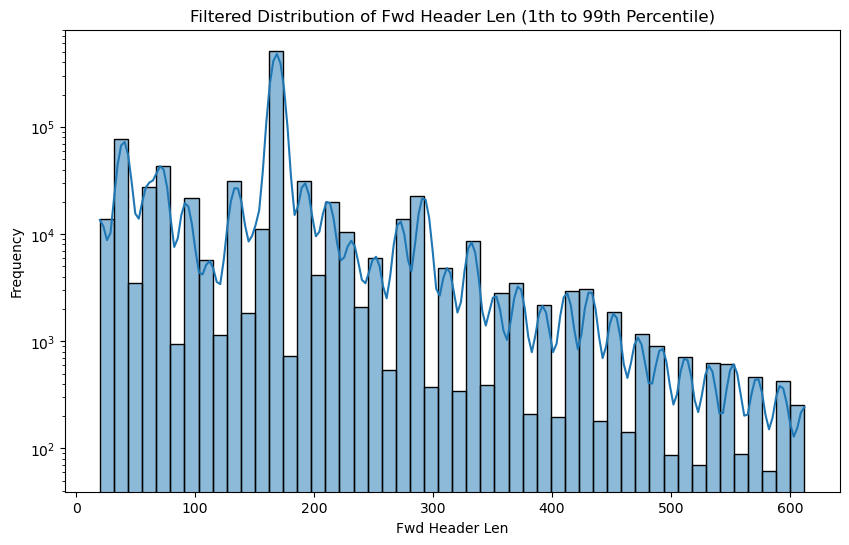

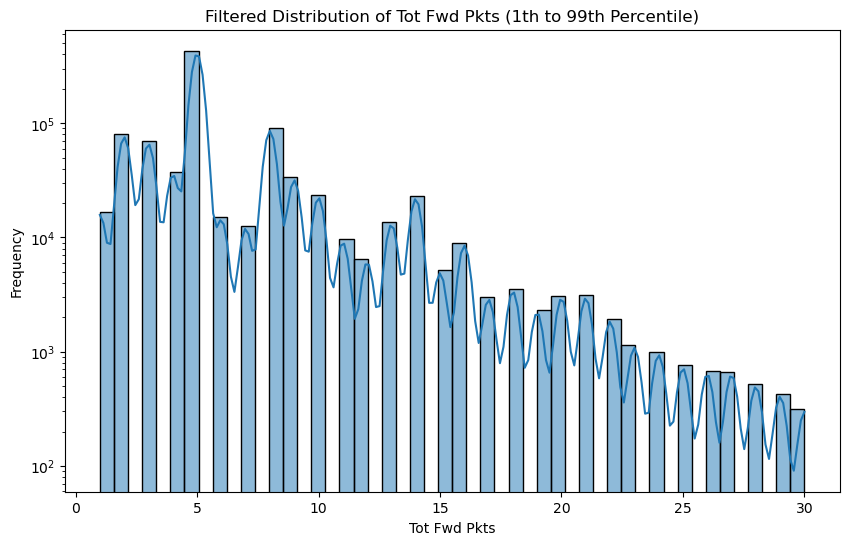

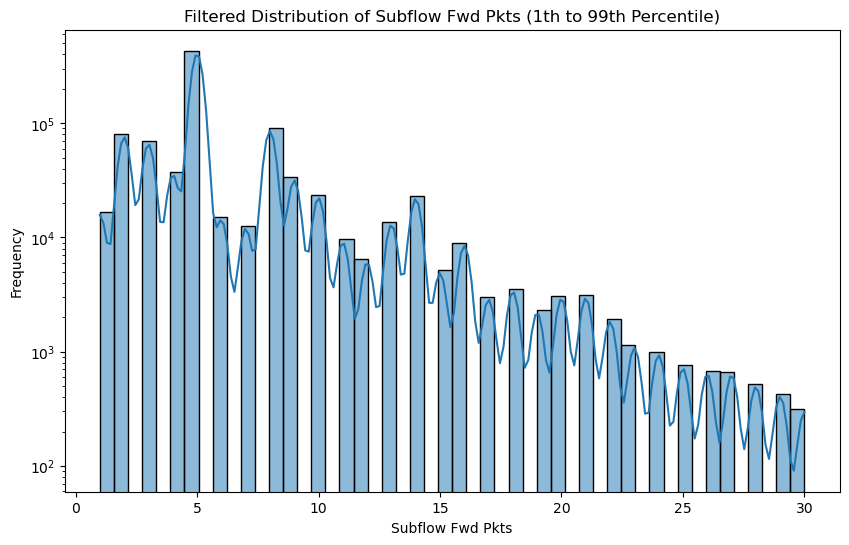

In [60]:
plot_filtered_distribution(tcp_benign_df, 'Fwd Header Len')
plot_filtered_distribution(tcp_benign_df, 'Tot Fwd Pkts')
plot_filtered_distribution(tcp_benign_df, 'Subflow Fwd Pkts')

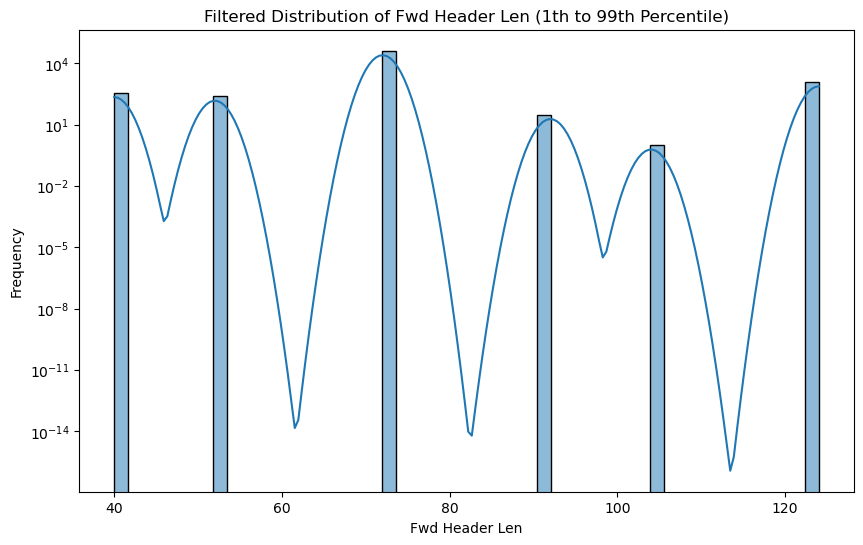

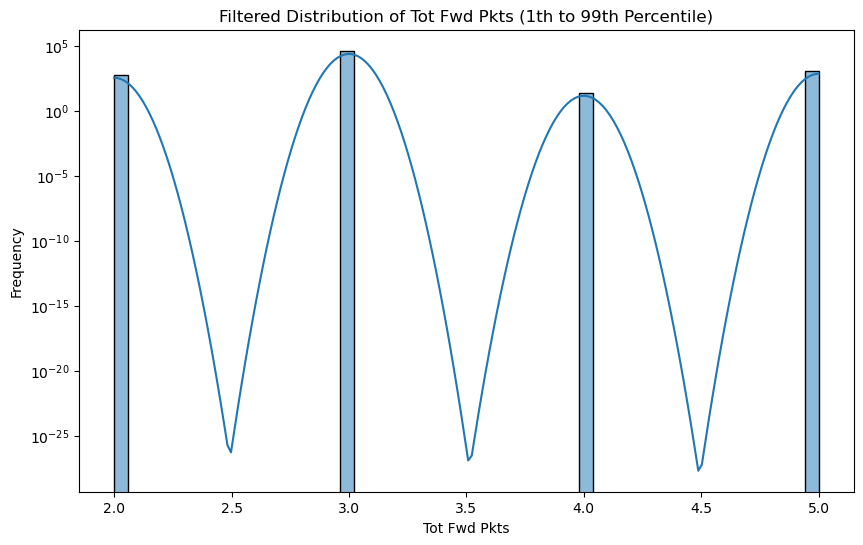

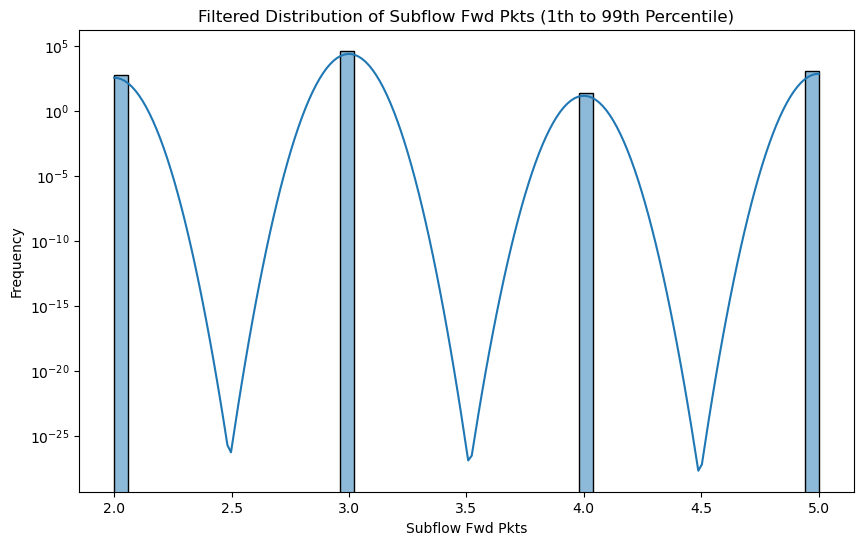

In [61]:
plot_filtered_distribution(bot_df, 'Fwd Header Len')
plot_filtered_distribution(bot_df, 'Tot Fwd Pkts')
plot_filtered_distribution(bot_df, 'Subflow Fwd Pkts')

## 8.5. Correlation Among Features
### 8.5.1. Feature Correlation Matrices
#### 8.5.1.1. Benign Samples

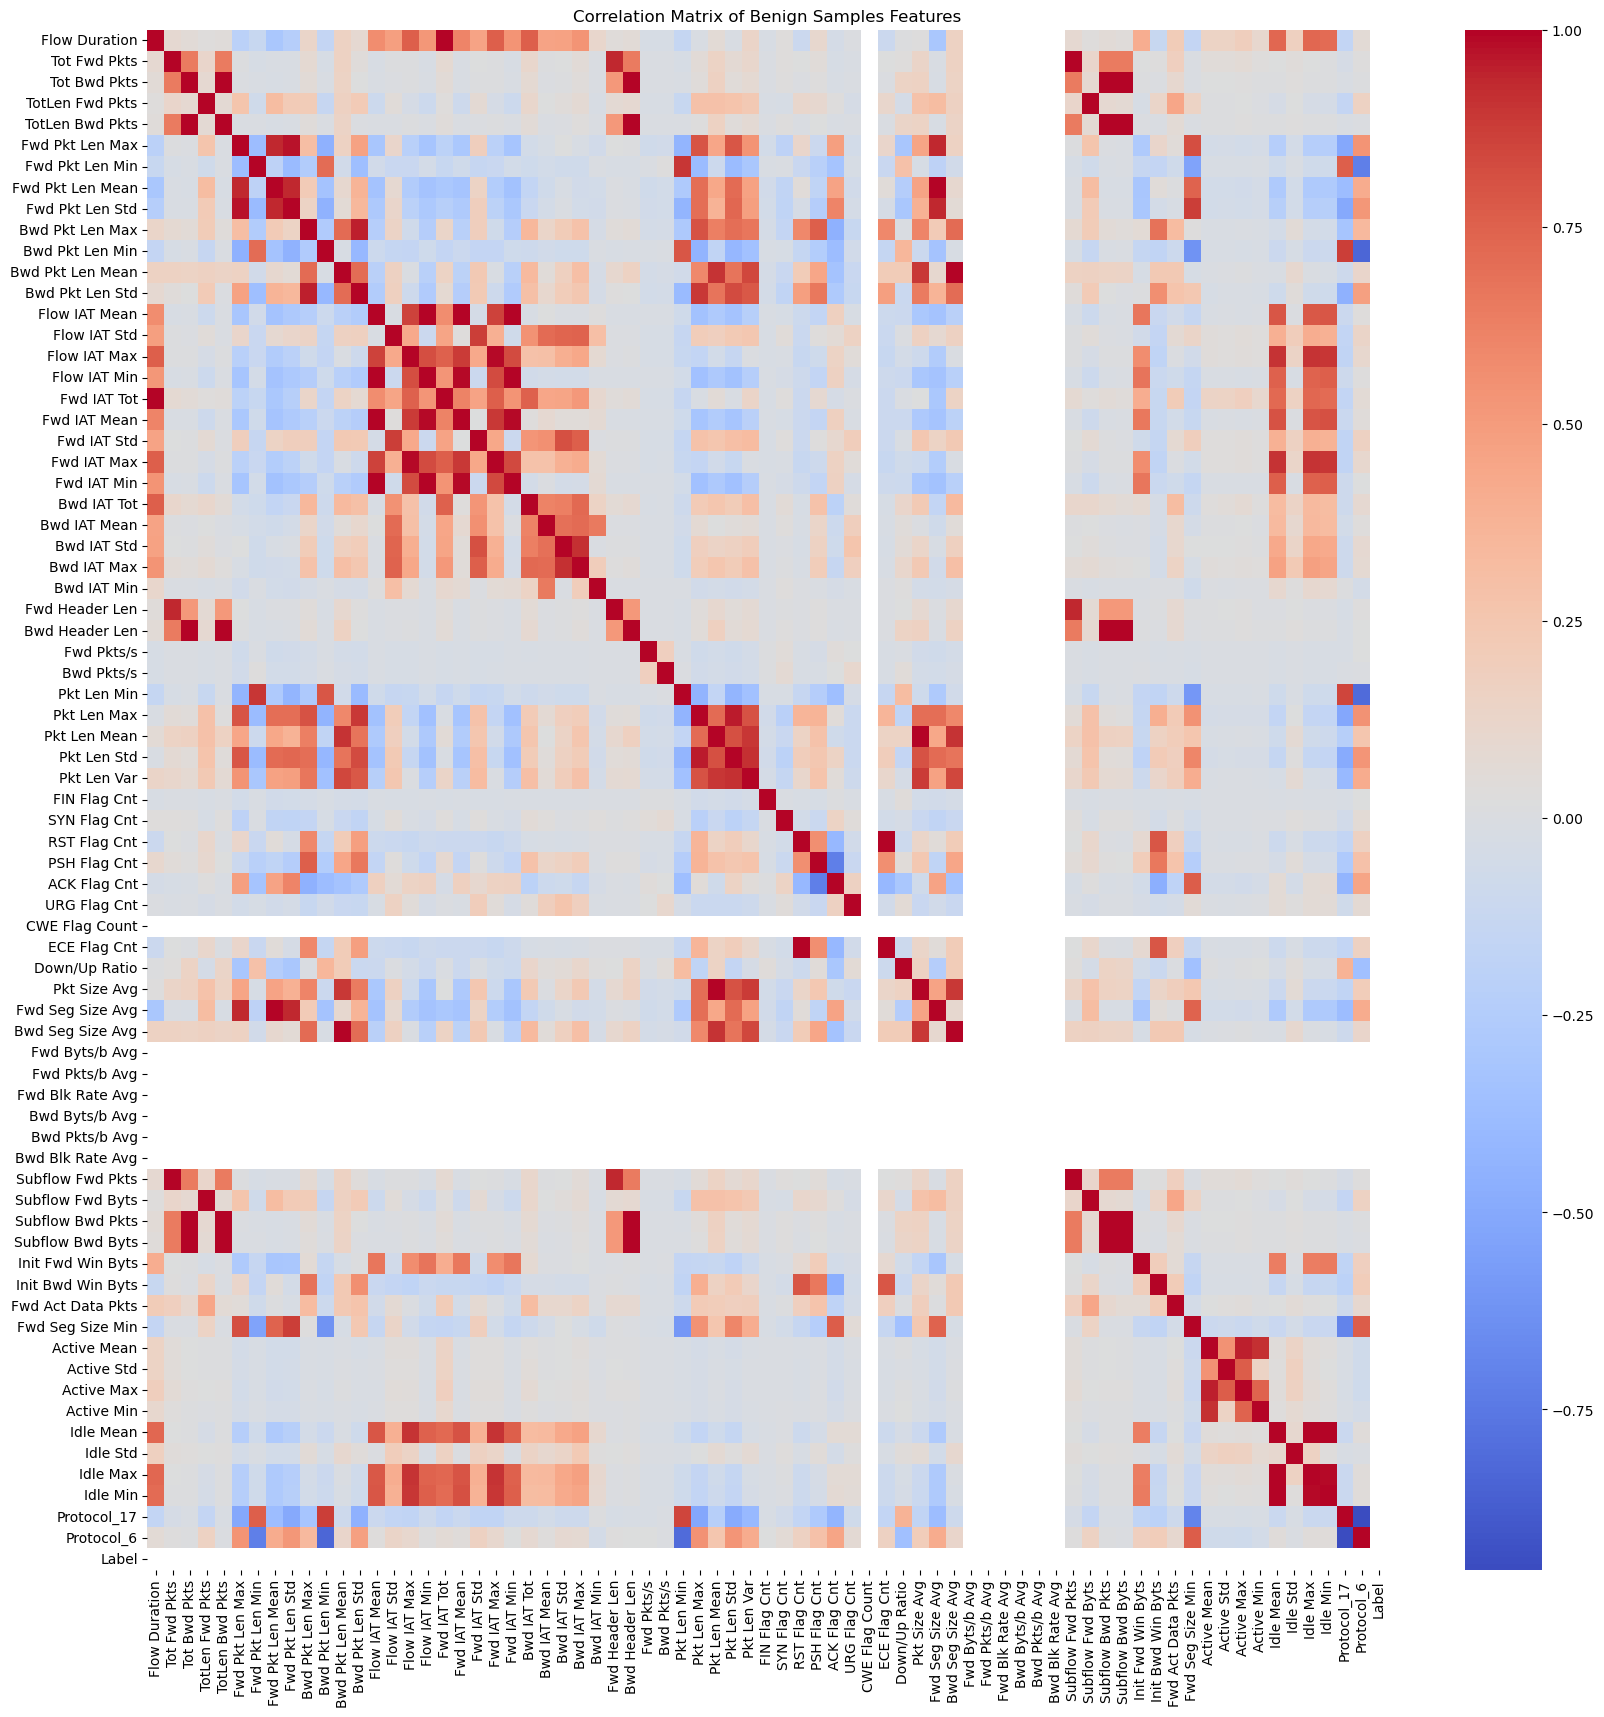

In [62]:
# calculate the correlation matrix for all numerical features
correlation_matrix_benign = benign_df.corr()

# plotting the correlation matrix with better visualization settings
plt.figure(figsize=(20, 20))  # increase the figure size
sns.heatmap(
    correlation_matrix_benign, 
    annot=False,  # set True to display the correlation values
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True,
    xticklabels=True,  # ensure all labels are shown
    yticklabels=True
)
plt.xticks(rotation=90)  # rotate x-axis labels for better visibility
plt.yticks(rotation=0)   # keep y-axis labels horizontal
plt.title("Correlation Matrix of Benign Samples Features")
plt.show()

In [63]:
# get correlations of Fwd Header Len with other features
fwd_header_len_correlations = correlation_matrix_benign['Fwd Header Len'].sort_values(ascending=False)

# display top correlations
#print(fwd_header_len_correlations)

# optionally filter out very low correlations for readability
threshold = 0.25  # define a threshold for "significant" correlations
significant_correlations = fwd_header_len_correlations[abs(fwd_header_len_correlations) > threshold]
print("\nSignificant correlations (>|0.25|):")
print(significant_correlations)


Significant correlations (>|0.25|):
Fwd Header Len      1.000000
Tot Fwd Pkts        0.935279
Subflow Fwd Pkts    0.935279
Bwd Header Len      0.517113
Subflow Bwd Pkts    0.516919
Tot Bwd Pkts        0.516919
TotLen Bwd Pkts     0.514877
Subflow Bwd Byts    0.514826
Name: Fwd Header Len, dtype: float64


#### 8.5.1.2 Bot Samples

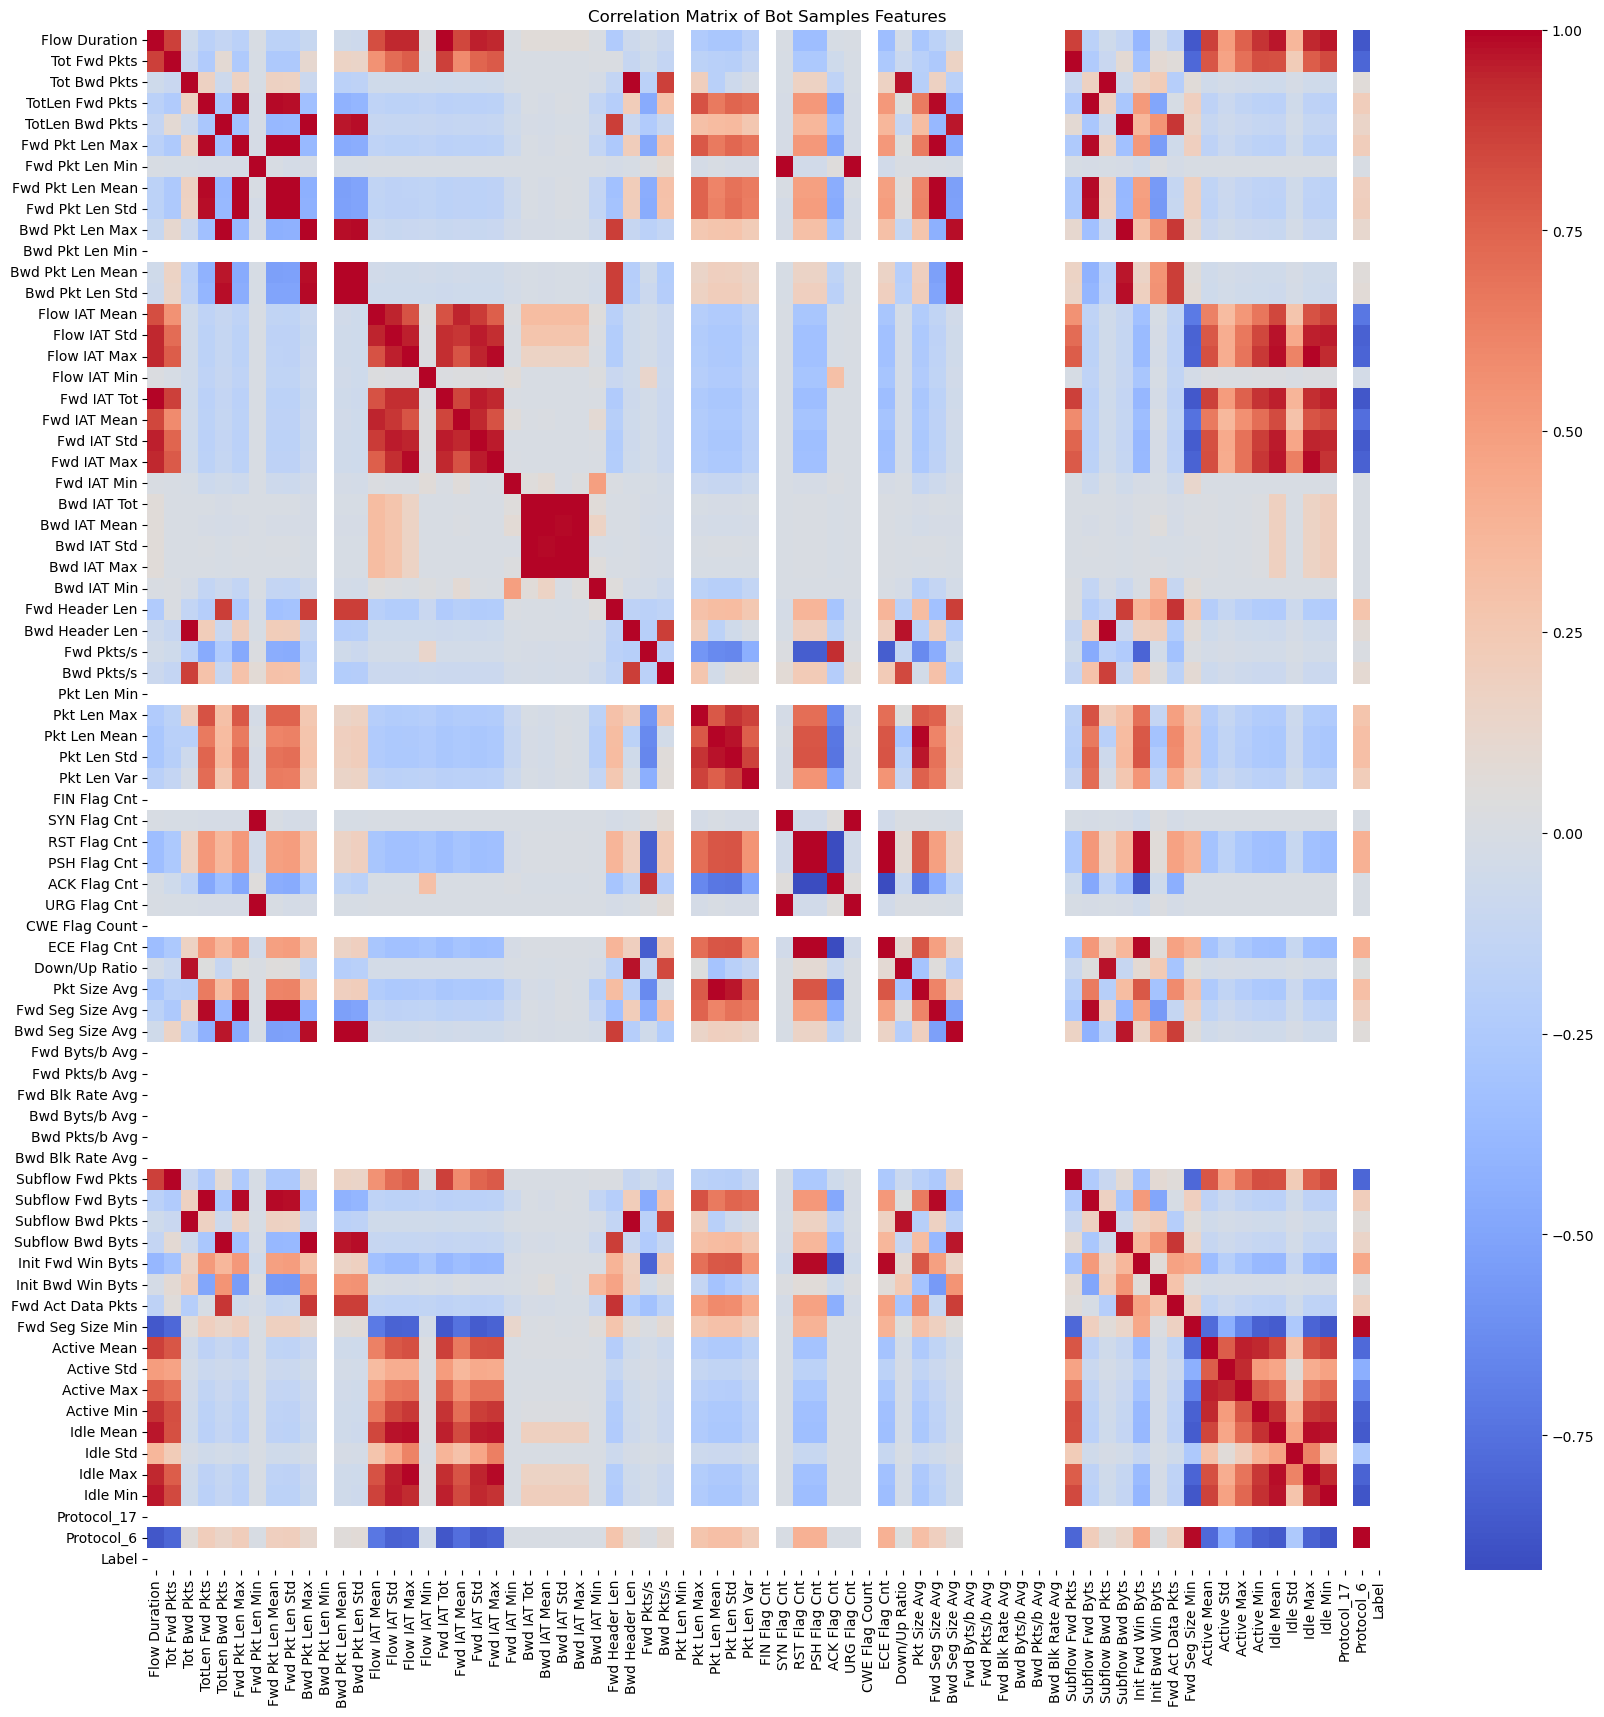

In [64]:
# calculate the correlation matrix for all numerical features
correlation_matrix_bot = bot_df.corr()

# plotting the correlation matrix with better visualization settings
plt.figure(figsize=(20, 20))  # increase the figure size
sns.heatmap(
    correlation_matrix_bot, 
    annot=False,  # set True to display the correlation values
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True,
    xticklabels=True,  # ensure all labels are shown
    yticklabels=True
)
plt.xticks(rotation=90)  # rotate x-axis labels for better visibility
plt.yticks(rotation=0)   # keep y-axis labels horizontal
plt.title("Correlation Matrix of Bot Samples Features")
plt.show()

### 8.5.2. Corrolation of "Flow Duration" Feature With Other Features

In [65]:
# extract the correlations with 'Flow Duration' and sort them
flow_duration_corr = correlation_matrix_benign['Flow Duration'].sort_values(ascending=False)

# display the correlations
print(flow_duration_corr)

Flow Duration        1.000000
Fwd IAT Tot          0.994859
Flow IAT Max         0.760834
Bwd IAT Tot          0.758098
Fwd IAT Max          0.756026
Idle Max             0.732584
Idle Mean            0.727461
Idle Min             0.715117
Fwd IAT Mean         0.609085
Flow IAT Mean        0.571148
Bwd IAT Max          0.535665
Fwd IAT Min          0.534993
Flow IAT Min         0.526462
Flow IAT Std         0.482444
Bwd IAT Std          0.466932
Fwd IAT Std          0.459138
Bwd IAT Mean         0.458542
Init Fwd Win Byts    0.412261
Fwd Act Data Pkts    0.209539
Active Max           0.186929
Idle Std             0.173798
Bwd Seg Size Avg     0.153689
Bwd Pkt Len Mean     0.153689
Active Std           0.150284
Active Mean          0.148309
Pkt Len Var          0.135221
Bwd Pkt Len Max      0.127953
Bwd IAT Min          0.109017
Active Min           0.105613
PSH Flag Cnt         0.100230
Tot Fwd Pkts         0.086052
Subflow Fwd Pkts     0.086052
Bwd Pkt Len Std      0.085385
Protocol_6

**NOTE:**
It seems that the correlation between Flow Duration and packet length features (Fwd Pkt Len Mean, Bwd Pkt Len Mean, Fwd Pkt Len Max, etc.) is relatively low.

This could suggests that, in this specific dataset, flow duration might not be directly influenced by packet length in a linear or straightforward way.

In real-world scenarios, packet length could still have an indirect impact on flow duration due to network congestion, bandwidth limitations, or other factors, but the relationship is not linear. 

## 8.6. Feature Importance

In [66]:
copy_df = df_dataset.copy()
copy_df = copy_df.drop(columns=['Label', 'Attack Name'])

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': copy_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


              Feature    Importance
47   Bwd Seg Size Avg  4.286881e-01
27     Fwd Header Len  3.225950e-01
14       Flow IAT Std  9.262693e-02
58  Init Fwd Win Byts  7.216375e-02
9     Bwd Pkt Len Max  2.849620e-02
41       URG Flag Cnt  1.687748e-02
7    Fwd Pkt Len Mean  1.549400e-02
36       FIN Flag Cnt  5.520604e-03
59  Init Bwd Win Byts  5.316299e-03
61   Fwd Seg Size Min  2.871620e-03
46   Fwd Seg Size Avg  2.453045e-03
1        Tot Fwd Pkts  2.167545e-03
18       Fwd IAT Mean  1.159058e-03
0       Flow Duration  9.011709e-04
29         Fwd Pkts/s  8.815918e-04
43       ECE Flag Cnt  2.735396e-04
19        Fwd IAT Std  2.498231e-04
65         Active Min  1.899613e-04
3     TotLen Fwd Pkts  1.809373e-04
62        Active Mean  1.257472e-04
37       SYN Flag Cnt  1.243620e-04
54   Subflow Fwd Pkts  1.165089e-04
56   Subflow Bwd Pkts  6.212426e-05
64         Active Max  6.067025e-05
55   Subflow Fwd Byts  5.868256e-05
20        Fwd IAT Max  5.616285e-05
17        Fwd IAT Tot  5.315

**NOTE:** Those feature importances are based on the model that trained with 2 classes 0 and 1 that does not differentiate between the different attacks.

# 9. Craft Adversarial Samples
## 9.1. Bot Samples
### 9.1.1. Increase Flow Duration and other Time Related Features 
#### 9.1.1.1. Modify DataFrame of Bot Samples

In [67]:
def modify_bot_to_appear_benign(df, target_duration_value):
    """
    Modify bot samples to increase flow duration and adjust related features to mimic benign traffic.
    
    Args:
        df (pd.DataFrame): dataframe containing bot samples.
        target_duration_value (float): base target flow duration to center around for bot samples.
    
    Returns:
        pd.DataFrame: modified dataframe with adjusted features.
    """
    # 1. introduce variability in the target flow duration
    df['Flow Duration'] = np.random.uniform(target_duration_value * 0.85, target_duration_value * 1.15, len(df))
    
    # 2. calculate row-wise scaling factors based on the new flow durations
    flow_scaling_factors = df['Flow Duration'] / df['Flow Duration'].mean()

    # 3. adjust inter-arrival times proportionally to the new flow durations
    for col in ['Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 
                'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min',
                'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd IAT Std', 'Bwd IAT Std']:
        random_factor = np.random.uniform(0.95, 1.05)  # slight variability for realism
        df[col] *= flow_scaling_factors * random_factor  # proportional adjustment with minor variability

    # 4. adjust standard deviations of inter-arrival times independently with slight variability
    #for col in ['Flow IAT Std', 'Fwd IAT Std', 'Bwd IAT Std']:
    #    std_random_factor = np.random.uniform(0.9, 1.1)  # smaller range for std adjustments
    #    df[col] *= std_random_factor  # independent adjustments for standard deviations

    # 5. calculate idle scaling factors based on flow scaling
    idle_scaling_factors = flow_scaling_factors * np.random.uniform(0.6, 1.2, len(df))  # add variability
    
    # scale idle values
    df['Idle Mean'] *= idle_scaling_factors
    df['Idle Max'] *= idle_scaling_factors
    df['Idle Min'] *= np.random.uniform(0.8, 1.2, len(df)) * idle_scaling_factors  # smaller range for min
    df['Idle Std'] *= np.random.uniform(0.9, 1.1, len(df))  # conservative adjustment for std

    return df


#### 9.1.1.2. Modify For Several Targets

In [68]:
def test_flow_duration_targets(model, bot_df, scaler, duration_targets):
    """
    Test different target flow duration values to find the optimal one for evasion.
    
    Args:
        model: Trained model to evaluate.
        bot_df (pd.DataFrame): DataFrame of bot samples to modify.
        scaler (MinMaxScaler): Scaler used to normalize data.
        duration_targets (list of float): List of target flow duration values to test.
    
    Returns:
        list of dicts: Each containing the target duration and resulting accuracy metrics.
    """
    results = []
    
    for target_duration in duration_targets:
        print(f"Testing with target flow duration: {target_duration}")
        
        # modify bot samples to have the fixed target flow duration
        modified_bot_df = modify_bot_to_appear_benign(bot_df.copy(), target_duration)
        
        # prepare the modified samples for evaluation using the helper function
        X_mod, y_mod, attack_names = prepare_for_evaluation(modified_bot_df, scaler)
        
        # evaluate the model on modified bot samples
        metrics = evaluate_model(model, X_mod, y_mod)
        metrics['target_duration'] = target_duration  # Log the target duration tested
        results.append(metrics)
        
        print(f"Results for duration {target_duration}: Accuracy: {metrics['accuracy']:.4f}\n")
    
    return results


#### 9.1.1.3. Results on Modified Bot Samples

In [69]:
# define specific target duration values for testing
duration_targets = [1.4e5, 1.5e5, 2e5, 2.5e5, 3e5, 5e5, 1e6, 5e6, 8e6, 1e7, 1.2e7]

# run the test with updated function name
crafted_bot_results = test_flow_duration_targets(model, bot_df, scaler, duration_targets)


Testing with target flow duration: 140000.0
accuracy: 0.99921
precision: 1.00000
recall: 0.99921
f1-score: 0.99961
confusion matrix:
[[    0     0]
 [   34 43264]]
Results for duration 140000.0: Accuracy: 0.9992

Testing with target flow duration: 150000.0
accuracy: 0.99903
precision: 1.00000
recall: 0.99903
f1-score: 0.99951
confusion matrix:
[[    0     0]
 [   42 43256]]
Results for duration 150000.0: Accuracy: 0.9990

Testing with target flow duration: 200000.0
accuracy: 0.46235
precision: 1.00000
recall: 0.46235
f1-score: 0.63234
confusion matrix:
[[    0     0]
 [23279 20019]]
Results for duration 200000.0: Accuracy: 0.4624

Testing with target flow duration: 250000.0
accuracy: 0.04571
precision: 1.00000
recall: 0.04571
f1-score: 0.08742
confusion matrix:
[[    0     0]
 [41319  1979]]
Results for duration 250000.0: Accuracy: 0.0457

Testing with target flow duration: 300000.0
accuracy: 0.04575
precision: 1.00000
recall: 0.04575
f1-score: 0.08750
confusion matrix:
[[    0     0]


#### 9.1.1.4. Plot Accuracy vs. Flow Duration

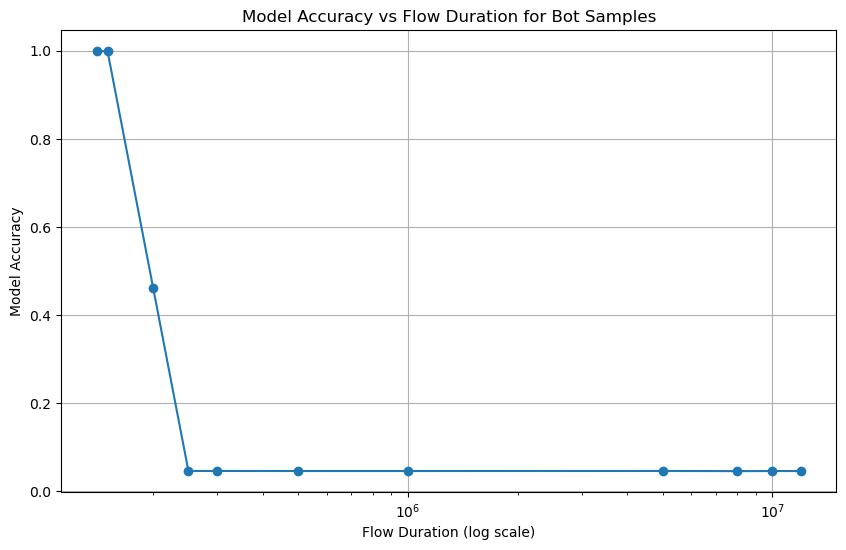

In [70]:
# extract target durations and accuracies from crafted_bot_results
durations = [result['target_duration'] for result in crafted_bot_results]
accuracies = [result['accuracy'] for result in crafted_bot_results]

# plot accuracy against flow duration
plt.figure(figsize=(10, 6))
plt.plot(durations, accuracies, marker='o', linestyle='-')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Flow Duration (log scale)')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs Flow Duration for Bot Samples')
plt.grid(True)
plt.show()

**NOTE:** We can see that the accuracies are still very high. 

The conclusion is that Flow Duration and all the other time related Features do not significantly contribute to the decision making of the model.

The DT must use other features to make decisions.

#### 9.1.1.5. Plot Flow Duration Distribution of Crafted Bot Samples 

In [71]:
target = 2e5

crafted_bot_target_2e5_df = modify_bot_to_appear_benign(bot_df, target)

X_crafted_bot_target_2e5, y_crafted_bot_target_2e5, _ = prepare_for_evaluation(crafted_bot_target_2e5_df, scaler) 

crafted_bot_target_2e5_results = evaluate_model(model, X_crafted_bot_target_2e5, y_crafted_bot_target_2e5)

accuracy: 0.46540
precision: 1.00000
recall: 0.46540
f1-score: 0.63519
confusion matrix:
[[    0     0]
 [23147 20151]]


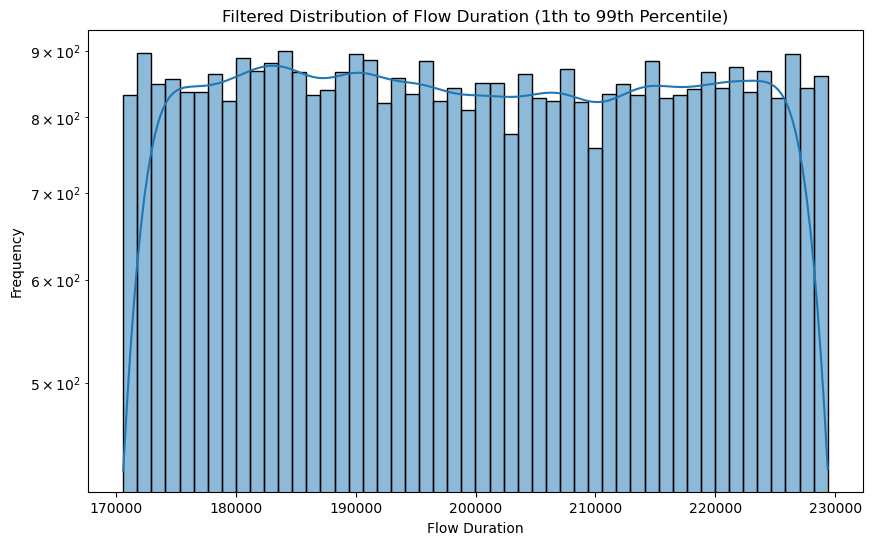

In [72]:
plot_filtered_distribution(crafted_bot_target_2e5_df, "Flow Duration")

**NEXT IDEA FOR BOT**: Inverstigate the packet count, packet length

### 9.1.2. Increase Packet Counts
#### 9.1.2.1. Modify DataFrame of Bot Samples

In [73]:
import numpy as np

def modify_bot_packet_counts(df):
    """
    Adjust forward packet counts to mimic benign traffic patterns, while keeping backward packet counts conservative.
    
    Args:
        df (pd.DataFrame): dataframe containing bot samples.
    
    Returns:
        pd.DataFrame: modified dataframe with adjusted packet counts.
    """
    # define benign ranges for packet counts
    benign_fwd_mean = 7  # approximate mean for benign forward packets
    
    # calculate scaling factors for forward packets
    fwd_scaling_factor = np.random.uniform(1.05, 1.3)  # moderate increase toward benign values
    
    # adjust forward packet counts
    df['Tot Fwd Pkts'] *= fwd_scaling_factor
    
    # clip forward packets to avoid exceeding benign realistic ranges
    df['Tot Fwd Pkts'] = np.clip(df['Tot Fwd Pkts'], 1, benign_fwd_mean * 10)  # allow higher range to reflect variability
    
    # adjust backward packets minimally, keeping malicious intent intact
    bwd_scaling_factor = np.random.uniform(0.8, 1.05)  # very slight increase or no change
    df['Tot Bwd Pkts'] *= bwd_scaling_factor
    
    # clip backward packets to avoid making them look too benign
    df['Tot Bwd Pkts'] = np.clip(df['Tot Bwd Pkts'], 0, benign_fwd_mean * 5)  # conservative upper bound
    
    return df


#### 9.1.2.2. Craft Bot Samples with Increased Packet Count

In [74]:
crafted_bot_count_df = modify_bot_to_appear_benign(bot_df, target)

X_crafted_bot_count, y_crafted_bot_count, _ = prepare_for_evaluation(crafted_bot_count_df, scaler) 

crafted_bot_count_results = evaluate_model(model, X_crafted_bot_count, y_crafted_bot_count)

accuracy: 0.45967
precision: 1.00000
recall: 0.45967
f1-score: 0.62983
confusion matrix:
[[    0     0]
 [23395 19903]]


**NOTE:** Not successfull

### 9.1.3. Modify Fwd Header Lengths and Related Features

In [75]:
import numpy as np
import pandas as pd

def modify_fwd_header_and_related_features(df, fwd_target, tcp_benign_stats=tcp_benign_stats, scaling_factor_range=(0.8, 1.2)):
    """
    Modify Fwd Header Len and propagate changes to related features based on benign TCP correlations.
    
    Args:
        df (pd.DataFrame): DataFrame containing bot samples.
        fwd_target (float): Target value for forward header length.
        scaling_factor_range (tuple): Range of scaling factors to apply to related features.
    
    Returns:
        pd.DataFrame: Modified DataFrame with adjusted features.
    """
    # modify Fwd Header Len close to the target value with slight variability
    df['Fwd Header Len'] = np.random.uniform(
        fwd_target * 0.85, fwd_target * 1.15, len(df)
    )
    df['Fwd Header Len'] = np.clip(df['Fwd Header Len'], 0, fwd_target * 1.5)  # cap at 150% of the target
    
    # calculate scaling factors for related features based on the new Fwd Header Len
    fwd_scaling_factors = df['Fwd Header Len'] / df['Fwd Header Len'].mean()
    
    # propagate changes to related features
    related_features = [
        "Tot Fwd Pkts", "Subflow Fwd Pkts", "Bwd Header Len", 
        "Tot Bwd Pkts", "TotLen Bwd Pkts", "Subflow Bwd Pkts", "Subflow Bwd Byts"
    ]
    
    for feature in related_features:
        # apply proportional scaling with variability
        variability = np.random.uniform(*scaling_factor_range, len(df))
        df[feature] *= fwd_scaling_factors * variability
        
        # introduce slight noise for realism
        noise = np.random.uniform(-0.05, 0.05, len(df))
        df[feature] += noise * df[feature]
        
        # cap the feature to avoid unrealistic values
        benign_stats = tcp_benign_stats.loc[feature]
        df[feature] = np.clip(df[feature], 0, benign_stats['max'])
    
    return df

In [76]:
def test_fwd_header_propagated_targets(model, bot_df, scaler, fwd_targets):
    """
    Test the impact of different Fwd Header Len target values on detection metrics,
    propagating changes to related features.
    
    Args:
        model: Trained model to evaluate.
        bot_df (pd.DataFrame): DataFrame of bot samples to modify.
        scaler (MinMaxScaler): Scaler used to normalize data.
        fwd_targets (list of float): List of forward header length target values to test.
    
    Returns:
        list of dicts: Each containing the tested target values and resulting accuracy metrics.
    """
    results = []
    
    for fwd_target in fwd_targets:
        print(f"Testing with Fwd Header Len Target: {fwd_target}")
        
        # modify Fwd Header Len and related features
        modified_bot_df = modify_fwd_header_and_related_features(bot_df.copy(), fwd_target)
        
        # prepare modified samples for evaluation
        X_mod, y_mod, attack_names = prepare_for_evaluation(modified_bot_df, scaler)
        
        # evaluate the model on modified bot samples
        metrics = evaluate_model(model, X_mod, y_mod)
        metrics['fwd_target'] = fwd_target
        results.append(metrics)
        
        print(f"Results for Fwd Header Len Target: {fwd_target}: "
              f"Accuracy: {metrics['accuracy']:.4f}\n")
    
    return results


In [ ]:
fwd_len_targets = [100, 150, 200, 300]
benign_tcp_stats = df_dataset[df_dataset["Protocol_6"] == 1].describe().transpose()
header_len_propagated_results = test_fwd_header_propagated_targets(model, bot_df, scaler, fwd_len_targets)

Testing with Fwd Header Len Target: 100
accuracy: 0.85577
precision: 1.00000
recall: 0.85577
f1-score: 0.92228
confusion matrix:
[[    0     0]
 [ 6245 37053]]
Results for Fwd Header Len Target: 100: Accuracy: 0.8558

Testing with Fwd Header Len Target: 150
accuracy: 0.85147
precision: 1.00000
recall: 0.85147
f1-score: 0.91978
confusion matrix:
[[    0     0]
 [ 6431 36867]]
Results for Fwd Header Len Target: 150: Accuracy: 0.8515

Testing with Fwd Header Len Target: 200
accuracy: 0.85216
precision: 1.00000
recall: 0.85216
f1-score: 0.92018
confusion matrix:
[[    0     0]
 [ 6401 36897]]
Results for Fwd Header Len Target: 200: Accuracy: 0.8522

Testing with Fwd Header Len Target: 300
accuracy: 0.85179
precision: 1.00000
recall: 0.85179
f1-score: 0.91997
confusion matrix:
[[    0     0]
 [ 6417 36881]]
Results for Fwd Header Len Target: 300: Accuracy: 0.8518



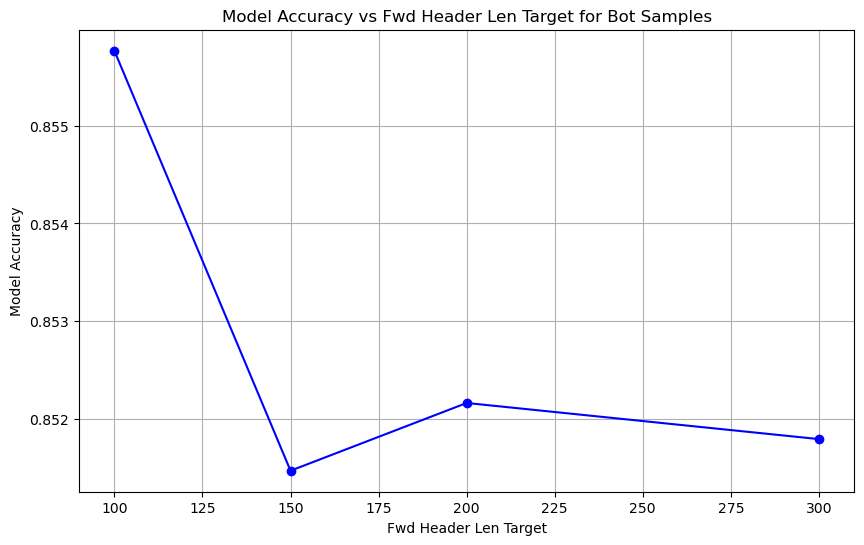

In [ ]:
# extract target Fwd Header Len values and accuracies from the test results
fwd_targets = [result['fwd_target'] for result in header_len_propagated_results]
accuracies = [result['accuracy'] for result in header_len_propagated_results]

# plot accuracy against Fwd Header Len target values
plt.figure(figsize=(10, 6))
plt.plot(fwd_targets, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Fwd Header Len Target')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs Fwd Header Len Target for Bot Samples')
plt.grid(True)
plt.show()
